## Analyze A/B Test Results

You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).  **Please save regularly.**

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [3]:
df.shape[0] # No of rows in df

294478

c. The number of unique users in the dataset.

In [4]:
df.nunique()

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

d. The proportion of users converted.

In [5]:
df['converted'].mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [6]:
df.query("group == 'treatment' and landing_page != 'new_page'").count()[0]

1965

f. Do any of the rows have missing values?

In [7]:
df.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
df2 = df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == True]
df2 = df2.copy() # create a copy to keep df unchanged 
df2.shape[0]

290585

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [10]:
df2.nunique()

user_id         290584
timestamp       290585
group                2
landing_page         2
converted            2
dtype: int64

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
raw_dublicate = (df2.user_id[df2.user_id.duplicated()]) # provides a fast answer to this question
raw_dublicate

2893    773192
Name: user_id, dtype: int64

In [12]:
df2.groupby('user_id').filter(lambda g: (g.nunique() > 1).any()) # takes a long time and yields the right answer 

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [13]:
df2.loc[2893]

user_id                             773192
timestamp       2017-01-14 02:55:59.590927
group                            treatment
landing_page                      new_page
converted                                0
Name: 2893, dtype: object

d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [14]:
df2.drop([2893], axis=0, inplace=True) 

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [15]:
df['converted'].mean()

0.11965919355605512

b. Given that an individual was in the `control` group, what is the probability they converted?

In [16]:
df2[df2['group'] == 'control']['converted'].mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [17]:
df2[df2['group'] == 'treatment']['converted'].mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [18]:
df2[df2['landing_page'] == 'new_page'].count()[0] / df2.shape[0]

0.50006194422266881

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**Answer**

>There is not sufficient evidence to say that the new treatment page leads to more conversions. In contrast, the data suggests that there is a slidly higher probability to convert for the control group who visited the old treatment page . 

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Answer**

**In this case, there is a question associated with a direction - that is the old page is better (i.e. more likely to lead to conversions) than the new page.  Since the probability for the new page is listed first here, the alternative would suggest that this is positive.**



$$H_0: p_{new} - p_{old} \leq 0$$


$$H_A: p_{new} - p_{old} > 0$$



`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [19]:
df2['converted'].mean()

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [20]:
df2['converted'].mean()

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [21]:
n_new = df2[df2['landing_page'] == 'new_page'].shape[0]
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [22]:
n_old = df2[df2['landing_page'] == 'old_page'].shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [23]:
bootsamp = df2.sample(n_new, replace = True)
new_page_converted = bootsamp['converted'].tolist()
new_page_converted = np.array(new_page_converted)
new_page_converted

array([0, 0, 0, ..., 0, 0, 0])

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [24]:
bootsamp = df2.sample(n_old, replace = True)
old_page_converted = bootsamp['converted'].tolist()
old_page_converted = np.array(old_page_converted)
old_page_converted

array([0, 0, 0, ..., 0, 0, 0])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [25]:
p_new = new_page_converted.mean()
p_old = old_page_converted.mean()

p_new_minus_p_old = p_new - p_old
p_new_minus_p_old

0.00059646471837976334

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [26]:
diffs = []

for _ in range(10000):
    bootsamp_new       = df2.sample(n_new, replace = True)
    bootsamp_old       = df2.sample(n_old, replace = True)
    new_page_converted = bootsamp_new['converted'].tolist()
    new_page_converted = np.array(new_page_converted)
    old_page_converted = bootsamp_old['converted'].tolist()
    old_page_converted = np.array(old_page_converted)
    p_new              = new_page_converted.mean()
    p_old              = old_page_converted.mean()
    p_diffs            = p_new - p_old
    
    diffs.append(p_diffs)
    
    
p_diffs = np.array(diffs)
p_diffs

array([-0.00064222,  0.0026134 , -0.00169517, ..., -0.00015332,
        0.0012987 ,  0.00204916])

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

Observed Difference (red line):  -0.00157823898536


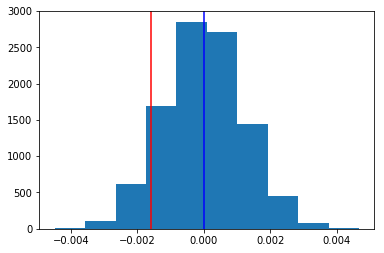

In [27]:
# plot p_diff distribution
plt.hist(p_diffs)

# plot line for observed statistic
obs_diff = df2[df2['group'] == 'treatment']['converted'].mean() - df2[df2['group'] == 'control']['converted'].mean()
plt.axvline(obs_diff, c='red')
plt.axvline(0, c='blue'); 
print('Observed Difference (red line): ',obs_diff)


j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [28]:
# proportion of the p_diffs greater than the actual difference observed in ab_data.csv
(p_diffs > obs_diff).mean()  # compute p-value

0.90620000000000001

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Answer**
>We have computed **p-values from bootstrapping samples** - An alternative method of obtaining the results of a hypothesis test. 
>The p-value shows the probability of observing our statistic or a more extreme statistic from the null hypothesis. The p-value tells us the **probability of committing a Type I error if the null hypothesis is true.** (A Type I error is when you incorrectly reject the null hypothesis - usually we would consider making Type I errors to be 'bad,' so we want to make as few of them as possible, and so are happy to err on the side of caution and make this chance quite low) 
$$H_0: p_{new} - p_{old} \leq 0$$
>
>A test of a statistical hypothesis, where the region of rejection is on only one side of the sampling distribution, is called a **one-tailed test**. Here, the null hypothesis states that the difference between p_new and p_old is less than or equal to 0. The alternative hypothesis states that the difference is greater than 0. The region of rejection would consist of a range of numbers located on the right side of sampling distribution; that is, a set of numbers greater than 0. 
>**The p-value of 0.9051 means that there is a 90.5% chance of committing a Type I error if we reject the null hypothesis. Therefore, we should not reject the null hypothesis.**-

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [29]:
import statsmodels.api as sm

convert_old = df2[df2['landing_page'] == 'old_page']['converted'].sum()
convert_new = df2[df2['landing_page'] == 'new_page']['converted'].sum()
n_old       = df2[df2['landing_page'] == 'old_page'].shape[0]
n_new       = df2[df2['landing_page'] == 'new_page'].shape[0]

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [30]:
count      = np.array([convert_old, convert_new])
nobs       = np.array([n_old, n_new])
stat, pval = sm.stats.proportions_ztest(count, nobs,alternative= 'smaller') 
# In the two sample test, smaller means that the alternative hypothesis is p1 < p2 (i.e. p_old < p_new)
#                      and larger means p1 > p2 where p1 is the proportion of the first sample and p2 of the second one.

print('z-score : ','{0:0.3f}'.format(stat))
print('p-value : ','{0:0.3f}'.format(pval))

z-score :  1.311
p-value :  0.905


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Answer**

>The **z-score states how many standard deviations it is away from the mean** and 95% of the cumulated standard normal probability distribution is 1.96 standard deviations away from the mean (i.e. between a z-score of -1.96 and 1.96). According to a standard normal distribution table, a z-score of 1.31 shows a probability of 0.9049. Therefore, a **z-score of 1.31 is equivalent to a p-value of 0.905.**  Both test statistics show that there is a 90.5% probability of committing a Type I error if the null hypothesis is true. 
>We should not reject the null hypothesis.
>The findings agree with the findings in part j. and k.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Answer**
>**Logistic Regression** predicts a probability between 0 and 1. We can apply logistic regression to predict the values in the converted column between the binary outcomes converted (i.e. +1) or no conversion (i.e. 0). Explanatory variables can be either categorical or quantitative.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [31]:
df2['intercept'] = 1
df2[['ab_page_2','ab_page',]] = pd.get_dummies(df2['group'])
df2 = df2.drop('ab_page_2', axis=1)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [32]:
import statsmodels.api as sm

log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']]) # Instantiate regression model on the two columns 
results = log_mod.fit() #  Fit the model using the two columns created in part b


Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [33]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 13 Jan 2020   Pseudo R-squ.:               8.077e-06
Time:                        15:23:06   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  

**Answer**
>The **p-value** associated with ab_page is **0.190** and it suggests that ab_page is not statistically significant in predicting the dependent variable 'converted'. This p-value tells us that there is a 19% probability of committing a Type I error if the null hypothesis is true. However, the  null and alternative hypotheses for this logistic regression differ from the  null and alternative hypotheses in Part II:
>
>$$H_0: \beta = 0$$
>$$H_A: \beta \neq 0$$
>
>In our logistic regression model the null hypothesis states that the probability for conversion is the same at each level of the independent variable ab_page. We cannot reject this null hypothesis on a 95% confidence level. Therefore, we cannot accept the alternative hypothesis that different values of ab_page change the probability for conversion (e.g. beta > 0 that the treatment group has a higher probability of conversion or beta < 0 for a lower probability).

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Answer**

>We could include dummy variables for weekday/weekend or morning, afternoon, evening derived from the timestamp. The timestamp shows entries in the mornings, afternoons and nighttime and the propensity to convert might be impacted by the time of the day.  Furthermore, we could try to get more personal data from the user_id database, if available. 



g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - Provide the statistical output as well as a written response to answer this question.

In [34]:
df_countries = pd.read_csv('countries.csv')
print(df_countries['country'].astype(str).value_counts())
df3 = df2.set_index('user_id').join(df_countries.set_index('user_id'))
df3[['US','UK','CA',]] = pd.get_dummies(df3['country'])
df3 = df3.drop('UK', axis=1)
log_mod = sm.Logit(df3['converted'], df3[['intercept','US','CA']]) 
results = log_mod.fit() #  Fit the model using the intercept column created in part b and one column each for the UK and CA
results.summary()                                         

US    203619
UK     72466
CA     14499
Name: country, dtype: int64
Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Mon, 13 Jan 2020   Pseudo R-squ.:               1.521e-05
Time:                        15:23:07   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9868      0.011   -174.174      0.000      -2.009      -1.964
US            -0.0507      0.028     -1.786      0.074      -0.106       0.005
CA            -0.0099      0.013     -0.746      0.456      -0.036       0.016
==============================================================================
"""

**Answer**

>The independent dummy variables US and CA are not statistically significant on a 95% confidence level. The p-values of 0.074 and 0.456 for US and CA, respectively, suggest that we should not reject the null hypothesis (i.e. we cannot reject beta = 0). However, the p-values for the countries vary depending on what dummy variables we choose and what country we leave out. Here, the UK is chosen as the 'default' country without dummy. Alternatively, we can choose CA as default without dummy, keeping US and UK. The vast majority of users are domiciled in the US (203,619 users or 70% of total users) and choosing the US as default country would limit the dummy variables to UK (72,466 users or 25% of total) and CA (14,499 users or 5% of total).
>
>**Alternatives (choose 2 dummy variables, leaving default country without dummy)**
>
>default UK:  p-value(US) = 0.074  p-value(CA) = 0.456   ==> do not reject null hypothesis
>
>default CA:  p-value(US) = 0.129  p-value(UK) = 0.456   ==> do not reject null hypothesis
>
>default US:  p-value(CA) = 0.129  p-value(UK) = 0.074   ==> do not reject null hypothesis
>
>**Therefore, it does not appear that country had an impact on conversion.**

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [35]:
log_mod = sm.Logit(df3['converted'], df3[['intercept','ab_page','US','CA']]) 
results = log_mod.fit() #  Fit the model using the intercept column created in part b and one column each for the US and CA
results.summary()  

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Mon, 13 Jan 2020   Pseudo R-squ.:               2.323e-05
Time:                        15:23:08   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9794      0.013   -155.415      0.000      -2.004      -1.954
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
US            -0.0506      0.028     -1.784      0.074      -0.106       0.005
CA            -0.0099      0.013     -0.743      0.457      -0.036       0.016
==============================================================================
"""

>**Alternatives** (choose ab_page dummy and 2 country dummy variables, leaving default country without dummy)
>
>**default UK:**  p-value(ab_page) = **0.191**    p-value(US) = 0.074  p-value(CA) = 0.457   ==> do not reject null hypothesis
>
>**default CA:**  p-value(ab_page) = **0.191**    p-value(US) = 0.130  p-value(UK) = 0.457   ==> do not reject null hypothesis
>
>**default US:**  p-value(ab_page) = **0.191**    p-value(CA) = 0.130  p-value(UK) = 0.074   ==> do not reject null hypothesis
>
> The p-value for the dummy variable ab_page does not depend on additional country dummy variables. The p-values for country dummy variables vary depending on what country is choosen as default without dummy. However, all of the independend dummy variables are not statistically significant on a 95% confidence level and we should not reject the null hypothesis.
>
>**It does not appear that ab_page or country had an impact on conversion.**

<a id='conclusions'></a>
## Finishing Up

> Congratulations!  You have reached the end of the A/B Test Results project!  You should be very proud of all you have accomplished!



## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [36]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0